# Vehicle detection

In [88]:
# data processing
# import importlib
# importlib.reload(helper)
import helper

# logging
import time

# manipulate directories and files
import os
import glob

# plotting
import matplotlib.pyplot as plt

# loading image
import matplotlib.image as mpimg

# math
import numpy as np

# hog features
from skimage.feature import hog

# OpenCV
import cv2

# normalization
from sklearn.preprocessing import StandardScaler

# classifier & dataset splitting
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split

#debugger
import pdb
# from IPython.core.debugger import set_trace

#checkpoints
import pickle

In [2]:
output_images_dir = 'output_images/'

## Data exploration


In order to train a classifier, we will use a dataset comprised of images taken from the [GTI vehicle image database](http://www.gti.ssr.upm.es/data/Vehicle_database.html), the [KITTI vision benchmark suite](http://www.cvlibs.net/datasets/kitti/), and examples extracted from the project video itself.

Here are links to the labeled data for [vehicle](https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/vehicles.zip) and [non-vehicle](https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/non-vehicles.zip) examples to train the classifier.

In [3]:
dataset_dir = "dataset"

helper.download_extract('vehicle', dataset_dir)
helper.download_extract('non-vehicle', dataset_dir)

Found vehicle Data
Found non-vehicle Data


In [4]:
# cars_path = os.path.join(dataset_dir, 'vehicles/**/*.png')

car_path = dataset_dir + "/vehicles/**/*.png"
# car_path = "examples/*.png"
cars_images = glob.glob(car_path, recursive=True)
cars = []

# print(len(cars_images))
# print(cars_images)
for image in cars_images:
    cars.append(image)

# notcars_path = os.path.join(dataset_dir, 'non-vehicles/**/*.png')
notcars_path = dataset_dir + "/non-vehicles/**/*.png"
# print(notcars_path)
notcars_images = glob.glob(notcars_path, recursive=True)
notcars = []

for image in notcars_images:
    notcars.append(image)
# print(len(notcars))

In [5]:
def data_look(car_list, notcar_list):
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    # Read in a test image, either car or notcar
    example_img = mpimg.imread(car_list[0])
    # Define a key "image_shape" and store the test image shape 3-tuple
    data_dict["image_shape"] = example_img.shape
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = example_img.dtype
    # Return data_dict
    return data_dict

The dataset contains 8792 cars and 8968 non-cars
of size:  (64, 64, 3)  and data type: float32


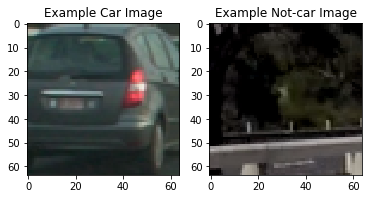

In [6]:
data_info = data_look(cars, notcars)

print('The dataset contains', 
      data_info["n_cars"], 'cars and', 
      data_info["n_notcars"], 'non-cars')
print('of size: ',data_info["image_shape"], ' and data type:', 
      data_info["data_type"])
# Just for fun choose random car / not-car indices and plot example images   
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))
    
# Read in car / not-car images# READ IN CAR / NOT-CAR IMAGES


car_image = mpimg.imread(cars[car_ind])
notcar_image = mpimg.imread(notcars[notcar_ind])

# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(car_image)
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(notcar_image)
plt.title('Example Not-car Image')
filename = output_images_dir + "car_notcar_example.png"
plt.savefig(filename)
plt.show()


## Features extraction

In [7]:
# Generate a random index to look at a car image
ind = np.random.randint(0, len(cars))
image = mpimg.imread(cars[ind])

### Histograms of colors

In [8]:
def color_hist_extended(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Generating bin centers
    bin_edges = channel1_hist[1]
    bin_centers = (bin_edges[1:] + bin_edges[0:len(bin_edges) - 1]) / 2
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features, channel1_hist, channel2_hist, channel3_hist, bin_centers

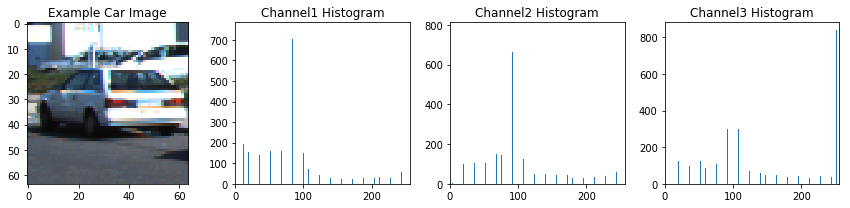

In [9]:
# rescale the image values from 0-1 to 0-255
img_scale = np.uint8(image * 255)
feature_vec, ch1h, ch2h, ch3h, bincen = color_hist_extended(img_scale, nbins=32, bins_range=(0, 256))

# Plot a figure with all three bar charts
if ch1h is not None:
    fig = plt.figure(figsize=(12,3))
    plt.subplot(141)
    plt.imshow(image)
    plt.title('Example Car Image')
    plt.subplot(142)
    plt.bar(bincen, ch1h[0])
    plt.xlim(0, 256)
    plt.title('Channel1 Histogram')
    plt.subplot(143)
    plt.bar(bincen, ch2h[0])
    plt.xlim(0, 256)
    plt.title('Channel2 Histogram')
    plt.subplot(144)
    plt.bar(bincen, ch3h[0])
    plt.xlim(0, 256)
    plt.title('Channel3 Histogram')
    fig.tight_layout()
    filename = output_images_dir + "histogram_colors.png"
    plt.savefig(filename)
    plt.show()
else:
    print('Your function is returning None for at least one variable...')

### Spatial binning of colors

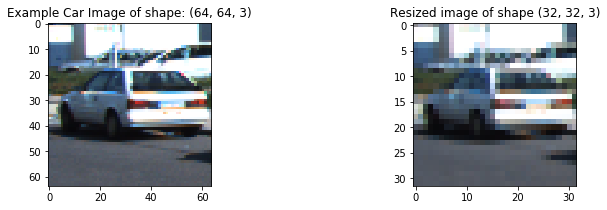

In [10]:
small_img = cv2.resize(image, (32, 32))
# Plot the examples
fig = plt.figure(figsize=(12, 3))
plt.subplot(121)
plt.imshow(image)
title = 'Example Car Image of shape: {}'.format(image.shape)
plt.title(title)
plt.subplot(122)
plt.imshow(small_img)
title = "Resized image of shape {}".format(small_img.shape)
plt.title(title)
filename = output_images_dir + "resized_image.png"
plt.savefig(filename)
plt.show()

While it could be cumbersome to include three color channels of a full resolution image, we can perform spatial binning on an image and still retain enough information to help in finding vehicles.

As we can see in the example above, even going all the way down to 32 x 32 pixel resolution, the car itself is still clearly identifiable by eye, and this means that the relevant features are still preserved at this resolution.

In [11]:
def bin_spatial(img, size=(32, 32)):
    """
    Compute binned color features  
    """
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

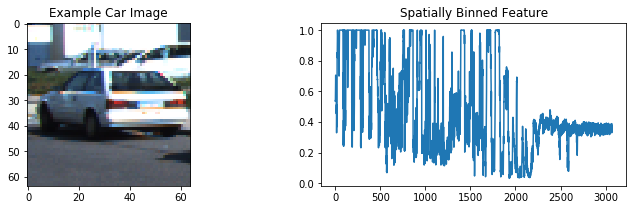

In [12]:
image_cspace = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
feature_vec = bin_spatial(image, size=(32, 32))

fig = plt.figure(figsize=(12, 3))
plt.subplot(121)
plt.imshow(image)
plt.title("Example Car Image")
plt.subplot(122)
plt.plot(feature_vec)
plt.title("Spatially Binned Feature")
filename = output_images_dir + "spatially_binned_feature.png"
plt.savefig(filename)
plt.show()

### HOG features

In [13]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    """
    Extract HOG features and ability to vizualiza the result
    """
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), 
                                cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True,
                                 visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    else:
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), 
                                cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True,
                                 visualise=vis, feature_vector=feature_vec)
        return features

/Users/virt/anaconda3/envs/autonomous-car/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


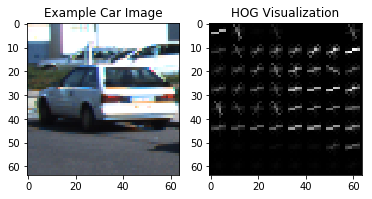

In [14]:
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

# HOG parameters
orient = 9
pix_per_cell = 8
cell_per_block = 2
features, hog_image = get_hog_features(gray, orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)

# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(image)
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')
filename = output_images_dir + "hog_visualization.png"
plt.savefig(filename)
plt.show()

### Combine and normalize features

Extract features from a bunch of images using a combination of HOG, spatial binning of features and the histograms of pixel intensity (color histograms).

In [15]:
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Generating bin centers
    bin_edges = channel1_hist[1]
    bin_centers = (bin_edges[1:] + bin_edges[0:len(bin_edges) - 1]) / 2
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

In [49]:
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      
        
#         print(feature_image.shape)
        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
#             print("spatial_feat  {}".format(len(spatial_features)))
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
#             print("hist features {}".format(len(hist_features)))
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
#             set_trace()
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
#             print("hog_features {}".format(len(hog_features)))
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features


In [101]:
# color_space = 'HLS' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (64, 64) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

In [102]:
car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
# print("\n\n")
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

/Users/virt/anaconda3/envs/autonomous-car/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


8792
8968
(17760, 18852)


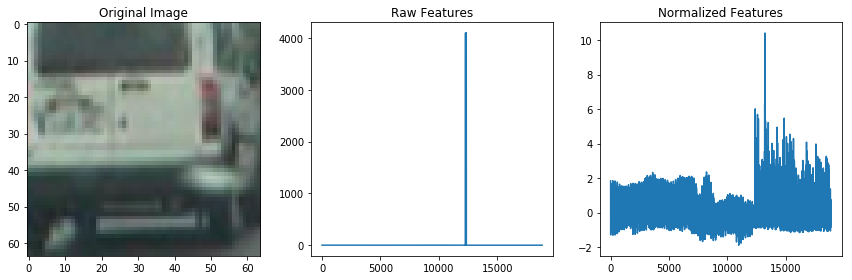

In [103]:
if len(car_features) > 0:
    # Create an array stack of feature vectors
    print(len(car_features))
    print(len(notcar_features))
    X = np.vstack((car_features, notcar_features)).astype(np.float64) 
    print(X.shape)
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)
    car_ind = np.random.randint(0, len(cars))
    # Plot an example of raw and scaled features
    fig = plt.figure(figsize=(12,4))
    plt.subplot(131)
    plt.imshow(mpimg.imread(cars[car_ind]))
    plt.title('Original Image')
    plt.subplot(132)
    plt.plot(X[car_ind])
    plt.title('Raw Features')
    plt.subplot(133)
    plt.plot(scaled_X[car_ind])
    plt.title('Normalized Features')
    fig.tight_layout()
    filename = output_images_dir + "normalized_features.png"
    plt.savefig(filename)
    plt.show()
else: 
    print('Your function only returns empty feature vectors...')

## Train a classifier

In [104]:
# define the label vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# split data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)
print('Using:',orient,'orientations',pix_per_cell,
    ',pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

Using: 11 orientations 8 ,pixels per cell and 2 cells per block
Feature vector length: 18852


In [105]:
svc = LinearSVC()
# Check the training time for the SVC
t = time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print("{} seconds to train SVC..".format(round(t2 - t, 2)))
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

45.68 seconds to train SVC..
Test Accuracy of SVC =  0.9851


### Checkpoint

In [106]:
svc_data = {
    "svc": svc,
    "scaler": X_scaler,
    "orient": orient,
    "pix_per_cell":pix_per_cell,
    "cell_per_block":cell_per_block,
    "spatial_size":spatial_size,
    "hist_bins":hist_bins
    
}
checkpoint_filename = "svc_pickle.p"
pickle.dump(svc_data, open(checkpoint_filename, 'wb'))

## Sliding windows search

In [107]:
test_images = glob.glob("./test_images/*.jpg")
images = []
for filename in test_images:
    image = mpimg.imread(filename)
    images.append(image)

In [108]:
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    
    # compute the span of the region to be searched
    x_span = x_start_stop[1] - x_start_stop[0]
    y_span = y_start_stop[1] - y_start_stop[0]
    
    # compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0] * (1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1] * (1 - xy_overlap[1]))
    
    # compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0] * xy_overlap[0])
    ny_buffer = np.int(xy_window[1] * xy_overlap[1])
    nx_windows = np.int((x_span - nx_buffer) / nx_pix_per_step)
    ny_windows = np.int((y_span - ny_buffer) / ny_pix_per_step)
    
    window_list = []
    # we could vectorize this step, but in practice we'll be considering windows
    # one by one with our classifier
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # calculate window position
            startx = np.int(xs * nx_pix_per_step + x_start_stop[0])
            endx = np.int(startx + xy_window[0])
            starty = np.int(ys * ny_pix_per_step + y_start_stop[0])
            endy = np.int(starty + xy_window[1])
            
            window_list.append(((startx, starty), (endx, endy)))
    return window_list

In [109]:
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    """
    Extract features from a single image window.
    This function is very similar to extract_features()
    just for a single image rather than list of images
    """
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        img_features.append(spatial_features)
#         print("spatial features {}".format(len(spatial_features)))
    if hist_feat == True:
        # Apply color_hist()
        hist_features = color_hist(feature_image, nbins=hist_bins)
        img_features.append(hist_features)
#         print("hist features {}".format(len(hist_features)))
    if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
#         pdb.set_trace()
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
              
#         print("hog features {}".format(len(hog_features)))
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)


In [110]:
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):
    """
    Extract features at each window position and predict with the classifier on each set of features
    """
    on_windows = [] #list to receive positive detection windows
#     print(len(windows))
    for window in windows:
        #extract window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))
        # extract features from this small image
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        # Scale extracted features to be fed to classifier
#         print(features.shape)
#         resized = np.array(features).reshape(1, -1)
#         print(resized.shape)
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        # predict using the classifier
        prediction = clf.predict(test_features)
        # is the prediction positive? If so, save the window: 1 - car, 0 - non car
        if prediction == 1:
            on_windows.append(window)
    return on_windows

In [111]:
img = images[0]
print("image shape: {}".format(img.shape))
y_start_stop = [0.5 * img.shape[0], None] # Min and max in y to search in slide_window()
print("Min/max in y to search in slide_window(): {}".format(y_start_stop))

image shape: (720, 1280, 3)
Min/max in y to search in slide_window(): [360.0, None]


In [112]:
windows = slide_window(img, x_start_stop=[None, None], 
                       y_start_stop=y_start_stop, xy_window=(96, 96),
                       xy_overlap=(0.3, 0.5))

hot_windows = search_windows(img, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)   

draw_image = np.copy(img)
window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)

/Users/virt/anaconda3/envs/autonomous-car/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


In [113]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    imcopy = np.copy(img)
    for bbox in bboxes:
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    return imcopy
        

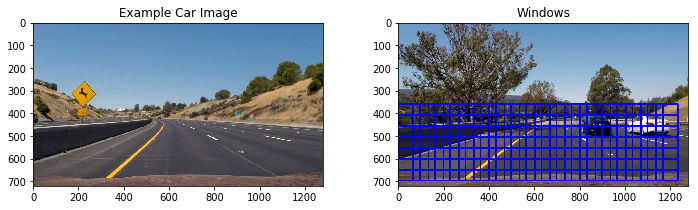

In [114]:
window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6) 

# Plot the examples
fig = plt.figure(figsize=(12, 3))
plt.subplot(121)
plt.imshow(image)
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(window_img)
plt.title('Windows')
filename = output_images_dir + "windows.png"
plt.savefig(filename)
plt.show()

## Improved windows search

We will apply a Hog Sub-sampling Window Search, that is to extract hog features once and then can be sub-sampled to get all of its overlaying windows. 

In [115]:
# load from checkpoint
dist_pickle = pickle.load( open("svc_pickle.p", "rb" ) )
svc = dist_pickle["svc"]
X_scaler = dist_pickle["scaler"]
orient = dist_pickle["orient"]
pix_per_cell = dist_pickle["pix_per_cell"]
cell_per_block = dist_pickle["cell_per_block"]
spatial_size = dist_pickle["spatial_size"]
hist_bins = dist_pickle["hist_bins"]

Each window is defined by a scaling factor where a scale of 1 would result in a window that's 8 x 8 cells then the overlap of each window is in terms of the cell distance. This means that a cells_per_step = 2 would result in a search window overlap of 75%. Its possible to run this same function multiple times for different scale values to generate multiple-scaled search windows.

In [116]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

In [119]:
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    """
    Extract features using hog sub-sampling and make predictions
    """    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
#             pdb.set_trace()
            X = np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1)
            test_features = X_scaler.transform(X)    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
    return draw_img

In [120]:
ystart = 400
ystop = 656
scale = 1.5

out_images = []
titles = []
for img in images:
    out_images.append(img)
    titles.append("Original")
    
    out_img = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    out_images.append(out_img)
    titles.append("Cars found")
    

/Users/virt/anaconda3/envs/autonomous-car/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


In [123]:
def display_images(images, titles=None, cols=2, cmap=None, filename=None, output_dir=output_images_dir):
    rows = (len(images) + 1) // cols
    plt.figure(figsize=(15, 17))
    for i in range(len(images)):
        plt.subplot(rows, cols, i + 1)
        image = images[i]
        cmap = 'gray' if len(image.shape)==2 else cmap
        plt.imshow(image, cmap=cmap)
        if titles:
            plt.title(titles[i])
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout()
    if filename:
        fname = output_dir + filename
        plt.savefig(fname)
        
    plt.show()

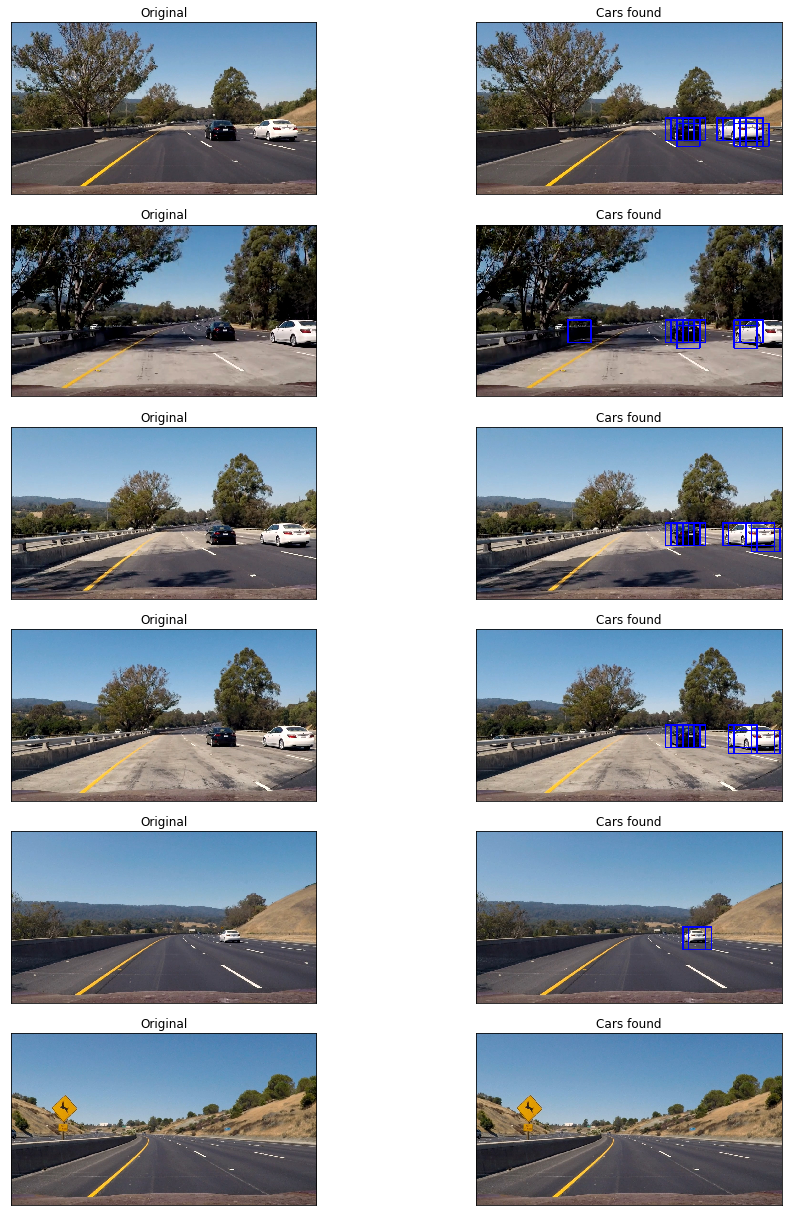

In [124]:
display_images(out_images, titles, cols=2, filename='hog_subsampling_window_search.png')